# Ensemble Mean
### Erica Simon, 02/20/24
## Purpose: calculate and visualize ensemble mean of temperature outcomes as generated by 3 different IAM emission trajectories
- calculates avg. temperature outcome for each config
- generates one distribution of 841 configs, rather than 3 x 841
- allows for more concise visualizations

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import pandas as pd

## Globals

In [2]:
weights_51yr = np.ones(52)
weights_51yr[0] = 0.5
weights_51yr[-1] = 0.5

In [3]:
scenario_order = ["Low demand", "Net Zero 2050", "Below 2 C", "Delayed transition", 
                  "Fragmented World", "NDCs", "Current Policies"]

In [4]:
NGFS_colors = {
    "Net Zero 2050": "#2274ae",
    "Below 2 C": "#003466",
    "NDCs": "#f69320",
    "Current Policies": "#df0000",
    "Low demand": "#00a9cf", 
    "Fragmented World": "#b0724e",
    "Delayed transition": "#92397a",
}

## Get datasets

In [5]:
# open temperature datasets
GCAM_ds = xr.open_dataset('~/outputs/GCAM_prob_run.nc')
MSG_ds = xr.open_dataset('~/outputs/MSG_prob_run.nc')
REM_ds = xr.open_dataset('~/outputs/REM_prob_run.nc')

## Calculate mean for each config

In [6]:
# calculate the mean temperature outcome for each config, averaged over all 3 probabilistic runs
def calc_ens_mean(ds_a, ds_b, ds_c):
    # calculate mean temp for each config
    mean_temps = (ds_a.temperature.values + ds_b.temperature.values + ds_c.temperature.values) / 3
    
    # copy format of input df for ens_mean
    ens_mean = ds_a.copy()
    
    # fill ens_mean df with mean temp values
    ens_mean.temperature.values = mean_temps
    
    return ens_mean

In [7]:
ens_mean = calc_ens_mean(GCAM_ds, MSG_ds, REM_ds)
ens_mean

<xarray.Dataset>
Dimensions:      (timebounds: 352, scenario: 7, config: 841, layer: 3)
Coordinates:
  * timebounds   (timebounds) float64 1.75e+03 1.751e+03 ... 2.1e+03 2.101e+03
  * scenario     (scenario) object 'Below 2 C' ... 'Net Zero 2050'
  * config       (config) int64 1234 2451 5859 5883 ... 1592589 1594247 1597937
  * layer        (layer) int64 0 1 2
Data variables:
    temperature  (timebounds, scenario, config, layer) float64 0.0 ... 0.3551

## Visualize

In [8]:
def calc_anomaly(f, scen):
    return f.temperature.loc[dict(scenario=scen, layer=0)]- np.average(
                        f.temperature.loc[
                            dict(scenario=scen, timebounds=np.arange(1850, 1902), layer=0)
                        ],
                        weights=weights_51yr,
                        axis=0
                        )

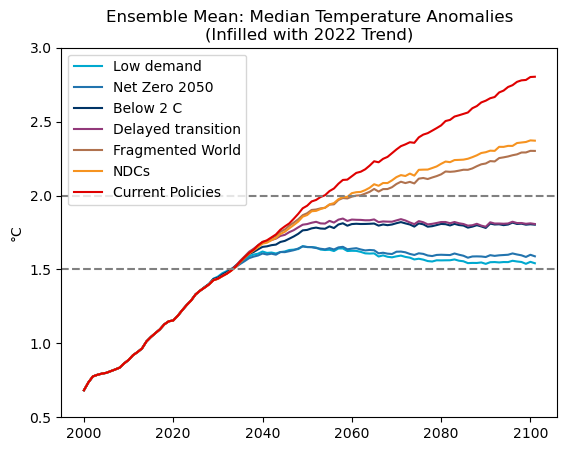

In [9]:
for i, scenario in enumerate(scenario_order):
    plt.plot(ens_mean.timebounds[250:], np.median(calc_anomaly(ens_mean, scenario), axis=1)[250:], label=scenario, color=NGFS_colors[scenario])
    
plt.legend()
plt.ylabel('°C')
plt.axhline(2, color='grey', linestyle='--')
plt.axhline(1.5, color='grey', linestyle='--')
plt.ylim(0.5,3)
plt.title('Ensemble Mean: Median Temperature Anomalies\n(Infilled with 2022 Trend)')
plt.show()

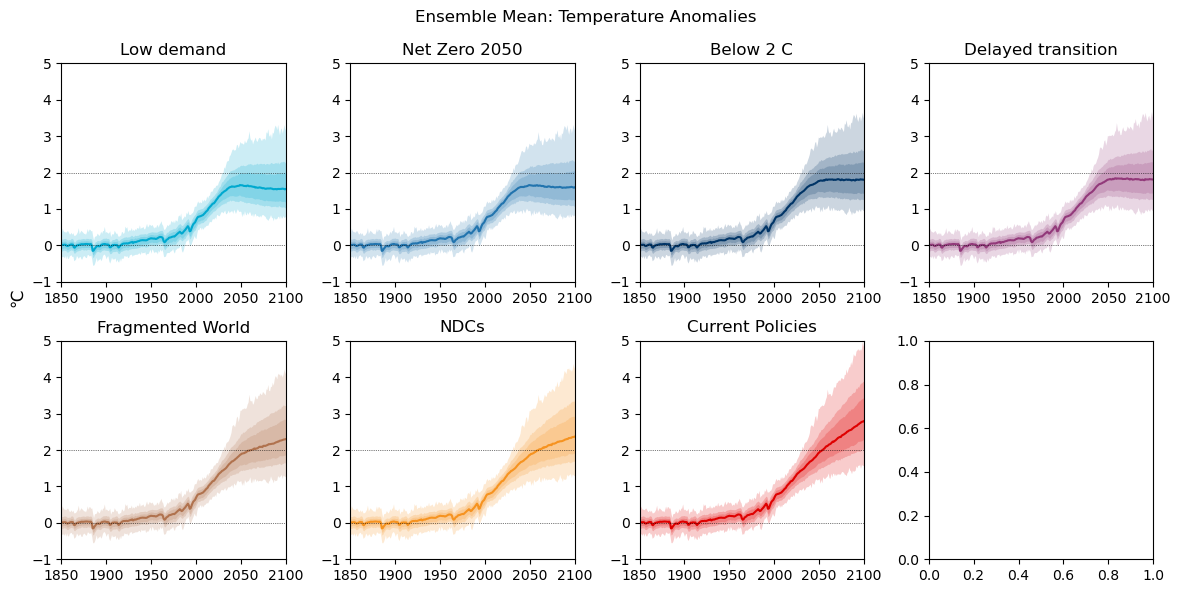

In [10]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

for i, scenario in enumerate(scenario_order):
    for pp in ((0, 100), (5, 95), (16, 84)):
        ax[i // 4, i % 4].fill_between(
            ens_mean.timebounds,
            np.percentile(
                ens_mean.temperature.loc[dict(scenario=scenario, layer=0)]
                - np.average(
                    ens_mean.temperature.loc[
                        dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                    ],
                    weights=weights_51yr,
                    axis=0
                ),
                pp[0],
                axis=1,
            ),
            np.percentile(
                ens_mean.temperature.loc[dict(scenario=scenario, layer=0)]
                - np.average(
                    ens_mean.temperature.loc[
                        dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                    ],
                    weights=weights_51yr,
                    axis=0
                ),
                pp[1],
                axis=1,
            ),
            color=NGFS_colors[scenario],
            alpha=0.2,
            lw=0
        )

    ax[i // 4, i % 4].plot(
        ens_mean.timebounds,
        np.median(
            ens_mean.temperature.loc[dict(scenario=scenario, layer=0)]
            - np.average(
                ens_mean.temperature.loc[
                    dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                ],
                weights=weights_51yr,
                axis=0
            ),
            axis=1,
        ),
        color=NGFS_colors[scenario],
    )
    ax[i // 4, i % 4].set_xlim(1850, 2100)
    ax[i // 4, i % 4].set_ylim(-1, 5)
    ax[i // 4, i % 4].axhline(0, color="k", ls=":", lw=0.5)
    ax[i // 4, i % 4].axhline(2, color="k", ls=":", lw=0.5)
    ax[i // 4, i % 4].set_title(scenario)

plt.suptitle('Ensemble Mean: Temperature Anomalies')
fig.supylabel('℃')
fig.tight_layout()

In [11]:
def plt_temp_distribs(xr, year, xmax=5, ymax=1.4):

    fig, ax = plt.subplots(2, 4, figsize=(12, 6))

    for i, scenario in enumerate(scenario_order):
        r, c = divmod(i, 4)
        
        temp_anom = xr.temperature.loc[dict(scenario=scenario, layer=0, timebounds=year)]- np.average(
                        xr.temperature.loc[
                            dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                        ],
                        weights=weights_51yr,
                        axis=0
                    )

        sns.kdeplot(temp_anom, ax=ax[r,c], color=NGFS_colors[scenario], fill=True, alpha=0.5)
        ax[r,c].set_title(scenario)
        ax[r,c].set_xlim(0, xmax)
        ax[r,c].set_ylim(0, ymax)

    plt.suptitle("Distribution of Temperature Anomalies in " + str(year) + '\nEnsemble Mean')
    fig.supxlabel('℃')
    fig.tight_layout()

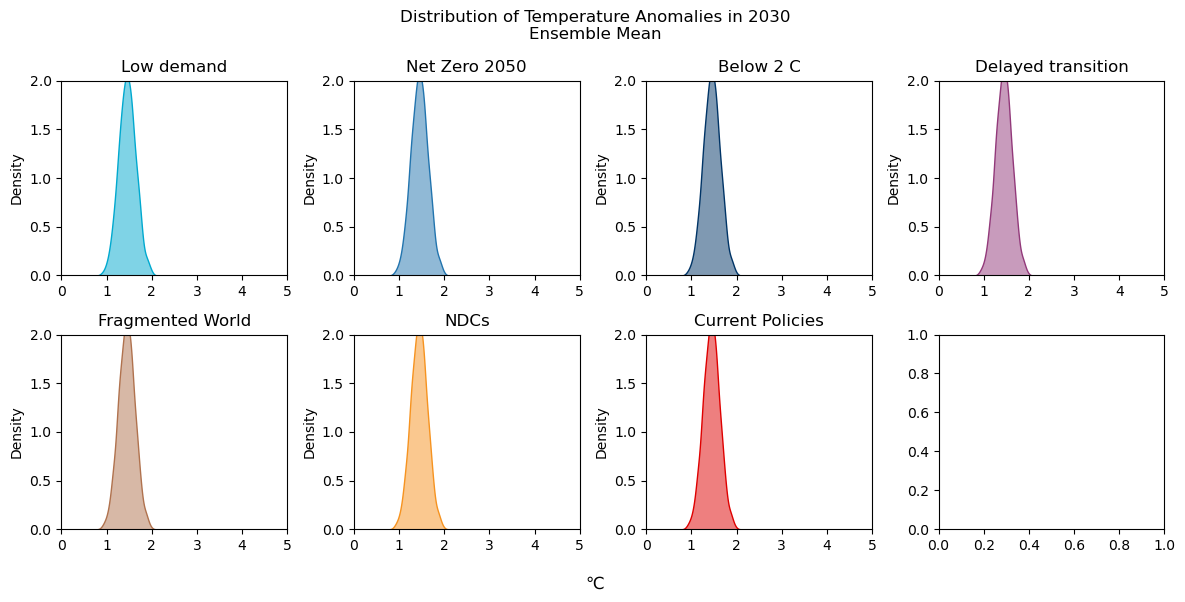

In [12]:
plt_temp_distribs(ens_mean, 2030, ymax=2)

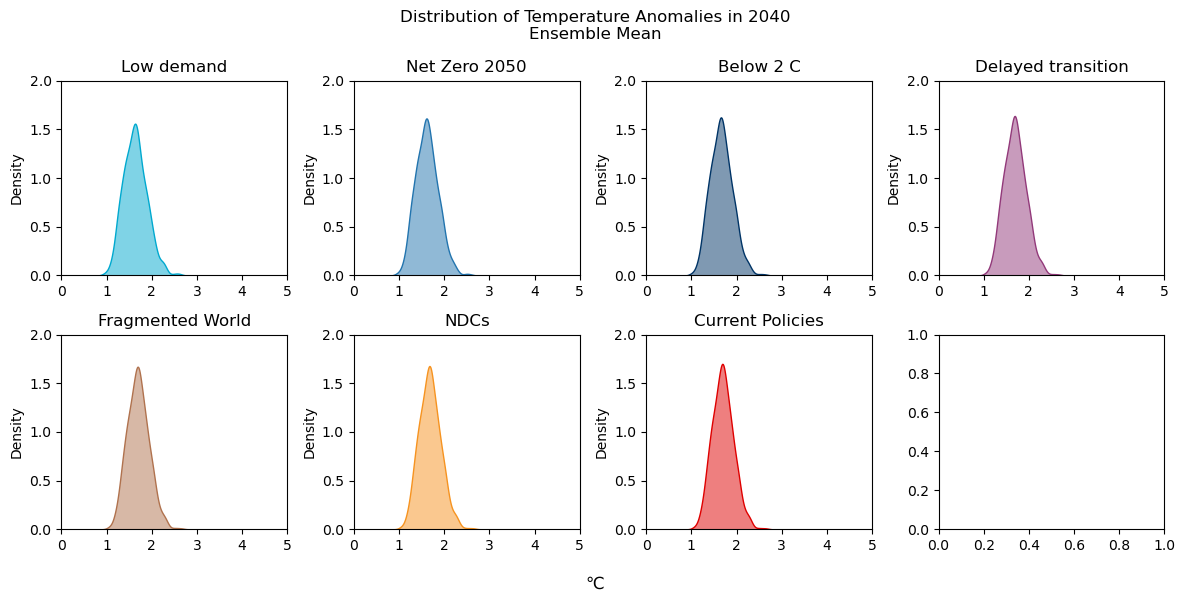

In [25]:
plt_temp_distribs(ens_mean, 2040, ymax=2)

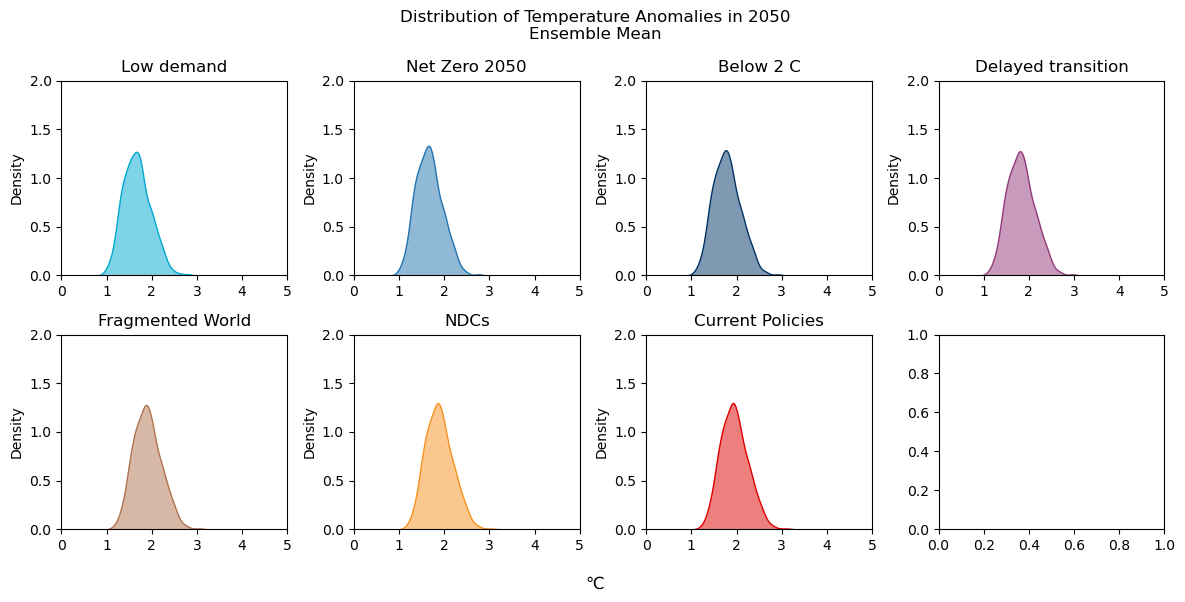

In [13]:
plt_temp_distribs(ens_mean, 2050, ymax=2)

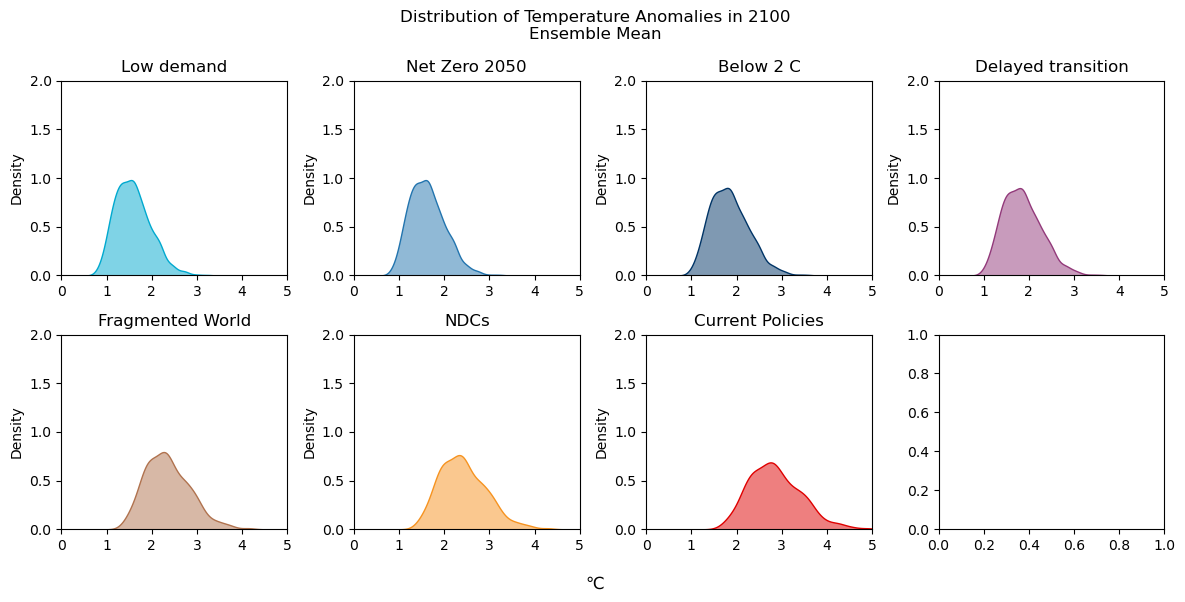

In [14]:
plt_temp_distribs(ens_mean, 2100, ymax=2)

### Percentile Analysis

In [15]:
def get_percentile(xr, year, lower_perc, upper_perc):
    
    perc_dict = {}

    for scenario in scenario_order:
        
        temp_anom = xr.temperature.loc[dict(scenario=scenario, layer=0, timebounds=year)]- np.average(
                        xr.temperature.loc[
                            dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                        ],
                        weights=weights_51yr,
                        axis=0
                    )
        
        a = round(np.percentile(temp_anom, lower_perc), 2)
        b = round(np.percentile(temp_anom, upper_perc), 2)
        
        perc_dict[scenario] = [a, b]
    
    return perc_dict

In [16]:
get_percentile(ens_mean, 2100, 95, 100)

{'Low demand': [2.24, 3.25],
 'Net Zero 2050': [2.29, 3.25],
 'Below 2 C': [2.57, 3.59],
 'Delayed transition': [2.59, 3.61],
 'Fragmented World': [3.22, 4.2],
 'NDCs': [3.33, 4.34],
 'Current Policies': [3.87, 4.95]}

In [17]:
def plt_temp_kde_tail(xr, year, lower_perc, upper_perc=100, xmin=2, xmax=5.3, ymax=0.3):

    fig, ax = plt.subplots(2, 4, figsize=(12, 6))

    for i, scenario in enumerate(scenario_order):
        r, c = divmod(i, 4)
        
        temp_anom = xr.temperature.loc[dict(scenario=scenario, layer=0, timebounds=year)]- np.average(
                        xr.temperature.loc[
                            dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                        ],
                        weights=weights_51yr,
                        axis=0
                    )
        
        a = np.percentile(temp_anom, lower_perc)
        b = np.percentile(temp_anom, upper_perc)

        sns.kdeplot(temp_anom, ax=ax[r,c], color=NGFS_colors[scenario], fill=True, alpha=0.5, clip=(a,b))
        ax[r,c].set_title(scenario)
        ax[r,c].set_xlim(xmin, xmax)
        ax[r,c].set_ylim(0, ymax)
        # ax[r,c].axvline(a, color="k", ls=":", lw=0.5)

    plt.suptitle(str(lower_perc) + "th percentile of Temperature Anomalies in " + str(year) + '\nEnsemble Mean ')
    fig.supxlabel('℃')
    fig.tight_layout()

In [18]:
def plt_temp_kde_tail2(xr, year, lower_perc, upper_perc=100, xmin=2, xmax=5.3, ylim=0.3):

    fig, ax = plt.subplots(1, 7, figsize=(12, 2))

    for i, scenario in enumerate(scenario_order):
        # r, c = (1, i)
        
        temp_anom = xr.temperature.loc[dict(scenario=scenario, layer=0, timebounds=year)]- np.average(
                        xr.temperature.loc[
                            dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                        ],
                        weights=weights_51yr,
                        axis=0
                    )
        
        a = np.percentile(temp_anom, lower_perc)
        b = np.percentile(temp_anom, upper_perc)

        sns.kdeplot(temp_anom, ax=ax[i], color=NGFS_colors[scenario], fill=True, alpha=0.5, clip=(a,b))
        ax[i].set_title(scenario)
        ax[i].set_xlim(xmin, xmax)
        ax[i].set_ylim(0, ylim)
        # ax[r,c].axvline(a, color="k", ls=":", lw=0.5)

    plt.suptitle(str(lower_perc) + "th percentile of Temperature Anomalies in " + str(year) + '\nEnsemble Mean')
    # fig.supxlabel('℃')
    fig.tight_layout()

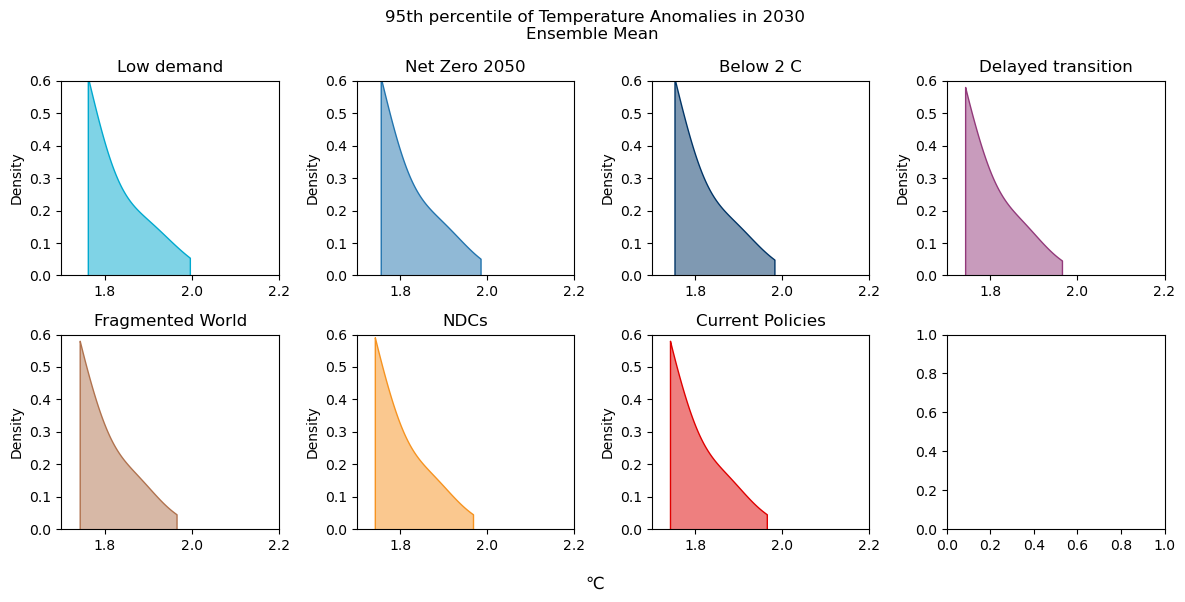

In [19]:
plt_temp_kde_tail(ens_mean, 2030, 95, xmin=1.7, xmax=2.2, ymax=0.6)

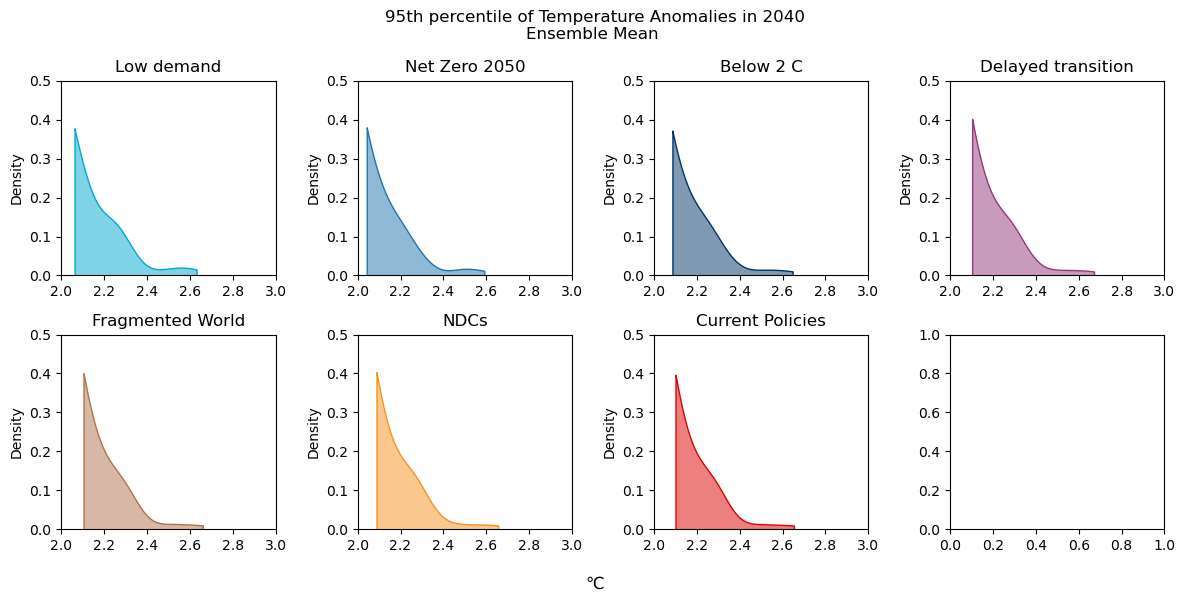

In [27]:
plt_temp_kde_tail(ens_mean, 2040, 95, xmin=2, xmax=3, ymax=0.5)

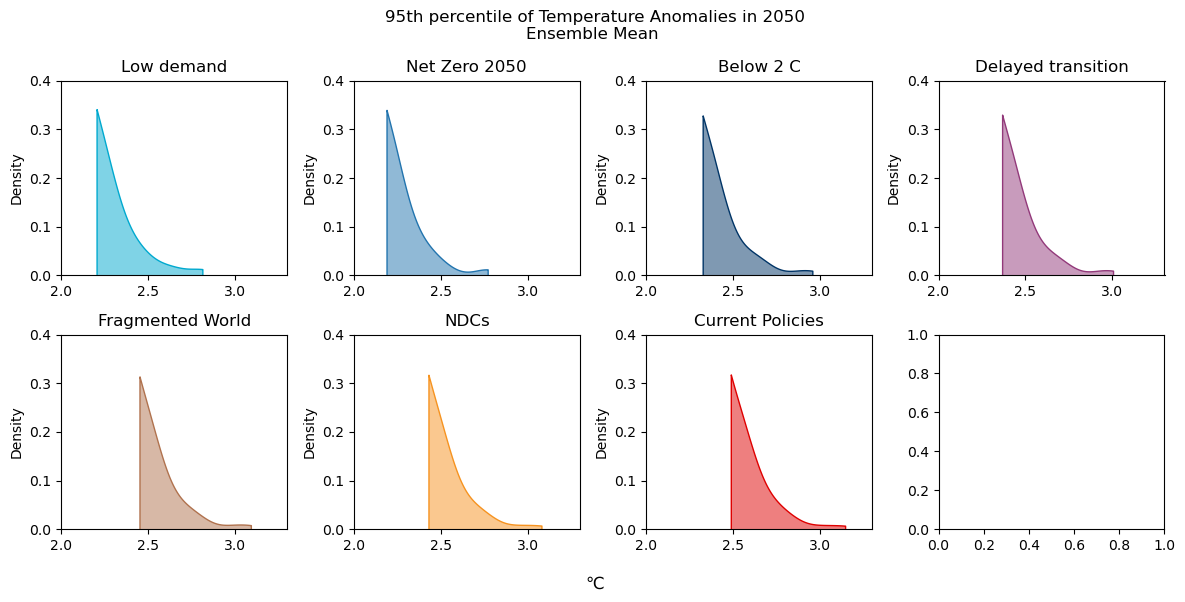

In [21]:
plt_temp_kde_tail(ens_mean, 2050, 95, xmin=2, xmax=3.3, ymax=0.4)

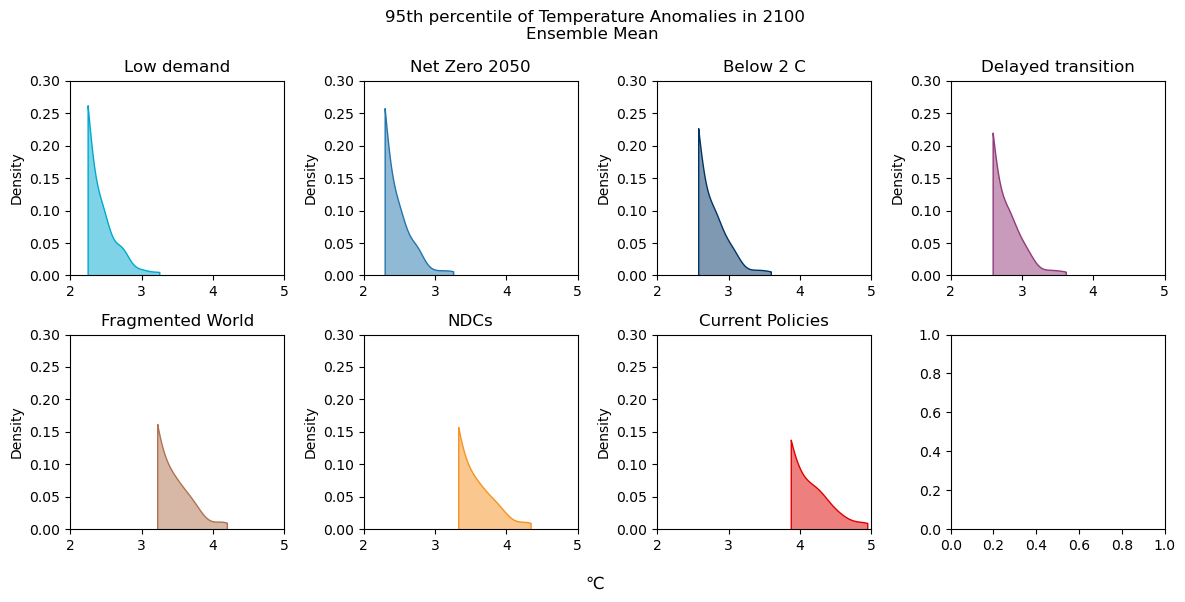

In [22]:
plt_temp_kde_tail(ens_mean, 2100, 95, xmax=5)

# Probabilistic bar chart
Trying to replicate fig in Ou, Y., et al. (2021). Can updated climate pledges limit warming well below 2°C? *Science, 374(6568),* 693–695. https://doi.org/10.1126/science.abl8976



In [23]:
def percs_in_temp_interval(ens_mean, scen, year=2100):
    intervals = np.array([0, 1.5, 2, 3, 4, 10])
    perc_dict = {}
    
    vals = calc_anomaly(ens_mean, scen)
    vals = vals.loc[vals.timebounds == year].values[0]
    
    counts, _ = np.histogram(vals, bins=intervals)
    
    for i in range(len(counts)):
        perc_dict[f"{intervals[i]} to {intervals[i+1]} ℃"] = counts[i] / len(vals) * 100
    
    
    perc_dict['<1.5 ℃'] = perc_dict.pop('0.0 to 1.5 ℃')
    perc_dict['1.5 to 2 ℃'] = perc_dict.pop('1.5 to 2.0 ℃')
    perc_dict['2 to 3 ℃'] = perc_dict.pop('2.0 to 3.0 ℃')
    perc_dict['3 to 4 ℃'] = perc_dict.pop('3.0 to 4.0 ℃')
    perc_dict['>4.0 ℃'] = perc_dict.pop('4.0 to 10.0 ℃')
    
    return perc_dict

In [28]:
perc_dict = {}

for scen in ens_mean.scenario.values:
    perc_dict[scen] = percs_in_temp_interval(ens_mean, scen)

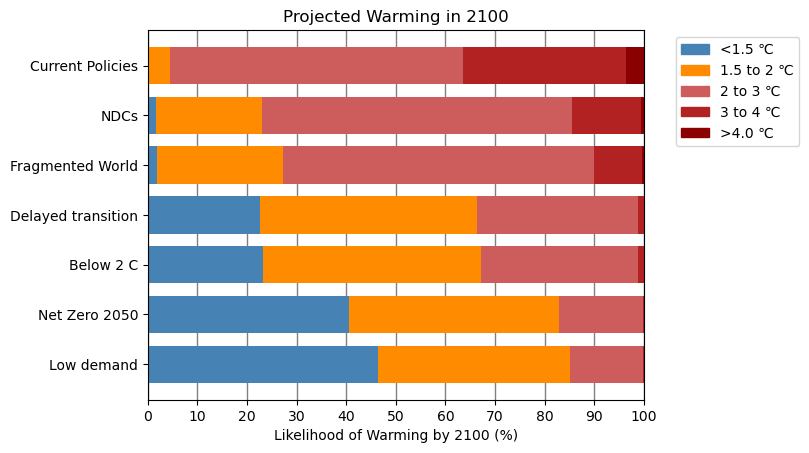

In [29]:
width = 0.75
ticks = np.arange(0,101,10)
colors = {'<1.5 ℃': 'steelblue', '1.5 to 2 ℃': 'darkorange', '2 to 3 ℃': 'indianred', 
          '3 to 4 ℃': 'firebrick', '>4.0 ℃': 'darkred'}

for n in ticks:
    plt.axvline(n, color='grey', lw=1, zorder=0)

for scen in scenario_order:
    left = 0
    for t in perc_dict[scen].keys():
        weight = perc_dict[scen][t]
        plt.barh(scen, weight, width, label=t, left=left, color=colors[t])
        left += weight
    
legend_handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in perc_dict[scen].keys()]
plt.legend(legend_handles, perc_dict[scen].keys(),  loc='upper left', bbox_to_anchor=(1.05, 1))


plt.xlim(0,100)
plt.xticks(ticks)
plt.xlabel('Likelihood of Warming by 2100 (%)')
plt.title('Projected Warming in 2100')
plt.show()
